## WeThink-Qwen2.5VL-7B

* From WeChat Vision
* Ranked #15 in OpenCompass multimodal academic leaderboard for open-source models (https://rank.opencompass.org.cn/leaderboard-multimodal)

    * https://huggingface.co/yangjie-cv/WeThink-Qwen2.5VL-7B
    * Can also be used to test Qwen2.5VL-7B-Instruct and perhaps other Qwen2.5VL models



In [1]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from transformers import Qwen2_5_VLForConditionalGeneration
from transformers.models.qwen2_5_vl.modeling_qwen2_5_vl import Qwen2_5_VLCausalLMOutputWithPast
from qwen_vl_utils import process_vision_info
import torch
import os
from typing import Optional, List, Tuple, Union

class CustomQwen2_5_VLForConditionalGeneration(Qwen2_5_VLForConditionalGeneration):
    def __init__(self, config, threshold=-0.5):
        super().__init__(config)
        self.threshold = threshold

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        pixel_values: Optional[torch.Tensor] = None,
        pixel_values_videos: Optional[torch.FloatTensor] = None,
        image_grid_thw: Optional[torch.LongTensor] = None,
        video_grid_thw: Optional[torch.LongTensor] = None,
        rope_deltas: Optional[torch.LongTensor] = None,
        cache_position: Optional[torch.LongTensor] = None,
        second_per_grid_ts: Optional[torch.Tensor] = None,
    ) -> Union[Tuple, Qwen2_5_VLCausalLMOutputWithPast]:
        # Call the parent class's forward method to get the outputs
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            labels=labels,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=True,  # Ensure hidden states are returned for modification
            return_dict=return_dict,
            pixel_values=pixel_values,
            pixel_values_videos=pixel_values_videos,
            image_grid_thw=image_grid_thw,
            video_grid_thw=video_grid_thw,
            rope_deltas=rope_deltas,
            cache_position=cache_position,
            second_per_grid_ts=second_per_grid_ts,
        )

        # Modify the hidden_states before logits are computed
        hidden_states = outputs.hidden_states[-1]  # Get the last hidden state
        #hidden_states = outputs.hidden_states[-1][-1]  # Get the last hidden state
        modified_hidden_states = self.modify_hidden_states(hidden_states)

        # Recompute logits using the modified hidden states
        logits = self.lm_head(modified_hidden_states)

        # Return the modified outputs
        if not return_dict:
            return (logits,) + outputs[1:]

        return Qwen2_5_VLCausalLMOutputWithPast(
            loss=outputs.loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions if outputs.attentions is not None else [],  # Safeguard for attentions
            rope_deltas=outputs.rope_deltas,
        )
    
    def modify_hidden_states(self, hidden_states):
        if self.threshold is not None:
            threshold = self.threshold
            hidden_states = torch.relu(hidden_states - threshold) + threshold
        return hidden_states


def get_model_processor(model_dir, device='cuda:0'):

    target_class = CustomQwen2_5_VLForConditionalGeneration


    model = target_class.from_pretrained(
        model_dir, 
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2",
    ).to(device)

    # default processer
    processor = AutoProcessor.from_pretrained(
        model_dir, 
        # # if not enough memory:
        # min_pixels=min_pixels, 
        # max_pixels=max_pixels,
    )

    return model, processor 



def get_response(image, question: str, model, processor, device='cuda:0'):
    messages = [
        {
            'role': 'system',
            'content': (
                "You FIRST think about the reasoning process as an internal monologue and then provide the final answer.\nThe reasoning process MUST BE enclosed within <think> </think> tags. The final answer MUST BE enclosed within <answer> </answer> tags."
            )
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": question},
            ],
        }
    ]
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(device)

    # Inference: Generation of the output
    #generated_ids = model.generate(**inputs, max_new_tokens=1000, do_sample=False, use_cache=True)
    generated_ids = model.generate(**inputs, max_new_tokens=2000, do_sample=False, use_cache=True)
    torch.cuda.empty_cache()
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    # print(output_text)


    return output_text[0]



/data/students/earl/anaconda3/envs/evalqwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]
/data/students/earl/anaconda3/envs/evalqwen/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


```json
[
	{"bbox_2d": [243, 260, 329, 375], "label": "batter's white pants"}
]
```
Bounding Boxes: [[243.0, 260.0, 329.0, 375.0]]


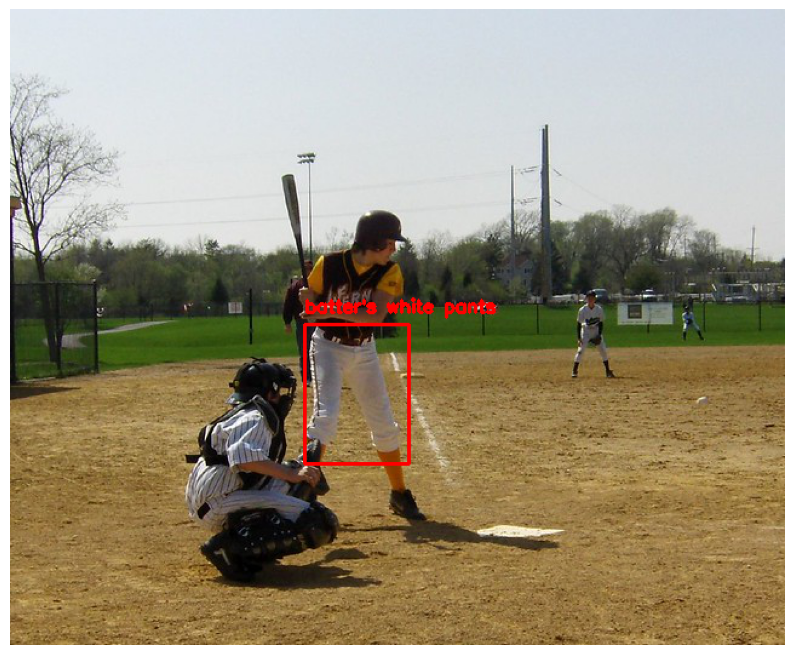

In [36]:
import io
import matplotlib.pyplot as plt
import re
import cv2
import numpy as np
from PIL import Image
import requests


#model_dir = '/data/students/earl/llava-dissector/WeThink-Qwen2.5VL-7B'
model_dir = '/data/students/earl/llava-dissector/Qwen2.5-VL-7B-Instruct'
device = 'cuda:4'
model, processor = get_model_processor(model_dir, device)


cls = "batter's white pants"
model.threshold = None #-1.5      #-2.5#-2.0 #-0.4 #-3.5 #-1.5

text = f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image'
image = url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg" #os.path.join('./assets/example.jpg')
response = get_response(
    image,
    f'<detect> {text}',
    #text,
    model, 
    processor,
    device=device,
)

print(response)

# regex the part of string to extract bounding boxes
#pattern = r'\[\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*\]'
#pattern = r'[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*[\]\)]'
pattern = r'(?:[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)(?:\s*[\]\)]|</box>))|(?:<box>\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*</box>)'
matches = re.findall(pattern, response)
bounding_boxes = []
for match in matches:
    nums = [x for x in match if x != '']
    if len(nums) == 4:
        bounding_boxes.append([float(x) for x in nums])

#bounding_boxes = [[int(coord) for coord in match] for match in matches]
print(f'Bounding Boxes: {bounding_boxes}')

# Visualize using cv2
# Load the original image for visualization
image_from_url = requests.get(url)
orig_img = Image.open(io.BytesIO(image_from_url.content)).convert('RGB')
img_cv = np.array(orig_img)  # HWC, RGB
for box in bounding_boxes:
    h, w, _ = img_cv.shape
    # Check if all coordinates are normalized (<= 1.0)
    if all(coord <= 1.0 for coord in box):
        x1, y1, x2, y2 = [int(coord * dim) for coord, dim in zip(box, [w, h, w, h])]
    else:
        x1, y1, x2, y2 = [int(coord) for coord in box]
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 
